<center><h1>Verbal Autopsy Clustering</h1></center>


<h1>Presentacion y datos</h1>

<h1>Bibliografia de momento</h1>

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

https://www.researchgate.net/publication/339529230_Preprocessing_Techniques_for_Text_Mining_-_An_Overview
***

Primero vamos a importar todo lo necesario para llevar a cabo la tarea de clustering

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import contractions
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem import PorterStemmer

Antes de empezar debemos crear un objeto a partir del archivo .csv que hemos escogido.

In [69]:
data = pd.read_csv("data/cleaned_PHMRC_VAI_redacted_free_text.train.csv")

Una vez creado aqui tenemos un pequeño ejemplo de lo que esta compuesto.

In [70]:
data.tail(5)

,newid,module,age,sex,site,open_response,gs_text34
5204,7120,Adult,42.0,1,UP,the deceased fell ill in the morning his breat...,Diabetes
5205,6101,Adult,14.0,2,Pemba,the respondant expained that the decease death...,Other Infectious Diseases
5206,6455,Adult,80.0,2,UP,the deceased had been admitted to hospital whe...,Pneumonia
5207,5026,Adult,70.0,1,UP,the deceased had been suffering from breathing...,Other Cardiovascular Diseases
5208,5326,Adult,30.0,1,Dar,the deceased died because of being hitted by a...,Other Injuries


Primero valoraremos si alguna de las instancias tiene algun valor null.

In [71]:
data_null = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5209 entries, 0 to 5208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   newid          5209 non-null   int64  
 1   module         5209 non-null   object 
 2   age            5209 non-null   float64
 3   sex            5209 non-null   int64  
 4   site           5209 non-null   object 
 5   open_response  5209 non-null   object 
 6   gs_text34      5209 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 285.0+ KB


No se aprecia ninguna entidad con valor null.

Ahora vamos a ilustrar la informacion de las muertes en un grafico.

En esta columna hay 5209 tipos de enfermedades


<BarContainer object of 48 artists>

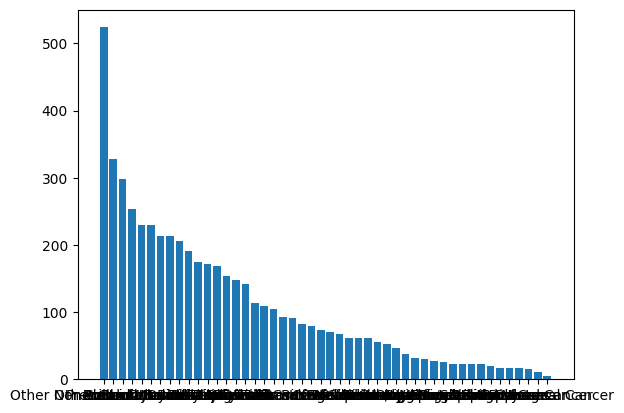

In [72]:
gs_text34 = data['gs_text34'].copy()
#plt.rcParams['figure.figsize'] = [40, 5]
print('En esta columna hay', gs_text34.size ,'tipos de enfermedades')
plt.bar(gs_text34.value_counts().index, gs_text34.value_counts())

Al haber 48 tipos de muertes en el archivo .csv no se llega a apreciar bien la informacion. Por lo tanto vamos a hacer grafico mas pequeño para poder entenderlo mejor

<BarContainer object of 10 artists>

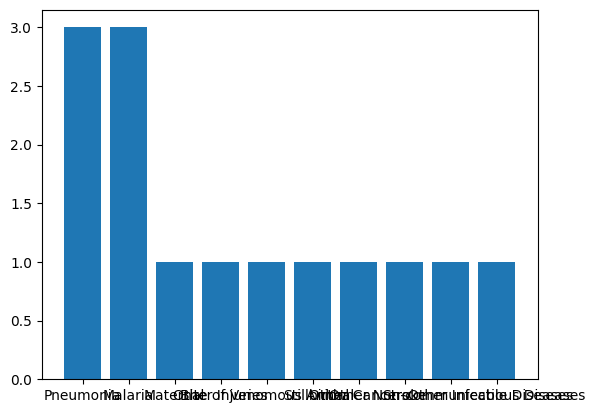

In [73]:
little_gs_text34 = gs_text34[0:14]
plt.bar(little_gs_text34.value_counts().index, little_gs_text34.value_counts())

Seleccionando solamente las 15 primera instancias del archivo .csv podemos apreciar que han habido 10 tipos diferentes de muerte y que solo dos de ellas se han repetido, en este caso 3 veces; Pneumonia y Malaria. 

<h1>PreProcesamiento</h1>

Vamos a dividir el preprocesamiento en distintos pasos:

1.

2.

3.

4.

5.

6.

<h2>Quitar columnas que no den infarmacion.</h2>

(Explicacion)

In [74]:
data.drop('newid', axis=1, inplace=True)
data.head(5)

,module,age,sex,site,open_response,gs_text34
0,Adult,65.0,1,Bohol,date he felt a lower back pain and had fever s...,Pneumonia
1,Child,0.0,2,Dar,the caese of death is pneumonia,Pneumonia
2,Adult,23.0,2,AP,i took my wife to a private hospital for tubec...,Maternal
3,Adult,40.0,1,AP,he went to the work on sunday there were # iro...,Other Injuries
4,Adult,55.0,1,UP,the deceased had died due to a snake bite the ...,Bite of Venomous Animal


<h2>1. Pasar a minusculas el texto</h2>

(Explicacion)
CREO QUE YA ESTABA TODO EN MINUSCULAS

In [75]:
data["open_response"] = data["open_response"].str.lower()
data.head(5)

,module,age,sex,site,open_response,gs_text34
0,Adult,65.0,1,Bohol,date he felt a lower back pain and had fever s...,Pneumonia
1,Child,0.0,2,Dar,the caese of death is pneumonia,Pneumonia
2,Adult,23.0,2,AP,i took my wife to a private hospital for tubec...,Maternal
3,Adult,40.0,1,AP,he went to the work on sunday there were # iro...,Other Injuries
4,Adult,55.0,1,UP,the deceased had died due to a snake bite the ...,Bite of Venomous Animal


<h2>2. Quitar marcas de puntuacion</h2>

(Explicacion)

In [76]:
def quitar_marcasPuntuacion(text:str):
    return text.translate(str.maketrans('', '', string.punctuation))

In [77]:
print(data["open_response"][45])

my mother suffered from fever continuously for # months she was treated in hospital where the doctor prescribed medicines but fever did not control later she was taken to hospital since the treatment was so expensive in the hospital the doctor advised us to take her to hospital but we did not take her to hospital but took her to hospital and admitted there since stains were present all over the body the doctors were firm to see the test results on the stains to proceed further on treatment by that time they were not specific to name the disease she was dead when the treatment was going on


In [78]:
data["open_response"] = data["open_response"].apply(lambda txt: quitar_marcasPuntuacion(txt))


In [79]:
print(data["open_response"][45])

my mother suffered from fever continuously for  months she was treated in hospital where the doctor prescribed medicines but fever did not control later she was taken to hospital since the treatment was so expensive in the hospital the doctor advised us to take her to hospital but we did not take her to hospital but took her to hospital and admitted there since stains were present all over the body the doctors were firm to see the test results on the stains to proceed further on treatment by that time they were not specific to name the disease she was dead when the treatment was going on


<h2>3. Extender las contracciones</h2>

In [80]:
def extender_contracciones(text):    
    expanded_words = []   
    for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  

    return ' '.join(expanded_words)

In [81]:
cntrtn_text = "I've to go the toilet, I can't wait."
print(cntrtn_text)
print(extender_contracciones(cntrtn_text))

I've to go the toilet, I can't wait.
I have to go the toilet, I cannot wait.


In [82]:
data["open_response"] = data["open_response"].apply(lambda txt: extender_contracciones(txt))

<h2>4. Stemming</h2>

In [83]:
stemmer = PorterStemmer()

def stem_palabras(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

In [84]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospital here in place the doctor was suspecting arthritis he was ordered for x ray so we went to hospital lab results are all normal but suddenly the complained of difficulty in breathing the doctor said that he has pneumonia oxygen inhalation was started and still he was weak and his blood sugar was elevated and he died the ff day


In [85]:
data["open_response"] = data["open_response"].apply(lambda text: stem_palabras(text))

In [86]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospit here in place the doctor wa suspect arthriti he wa order for x ray so we went to hospit lab result are all normal but suddenli the complain of difficulti in breath the doctor said that he ha pneumonia oxygen inhal wa start and still he wa weak and hi blood sugar wa elev and he die the ff day


<h2>5. Lematizacion</h2>

In [87]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

def lematizar_palabras(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /home/peio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/peio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [88]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospit here in place the doctor wa suspect arthriti he wa order for x ray so we went to hospit lab result are all normal but suddenli the complain of difficulti in breath the doctor said that he ha pneumonia oxygen inhal wa start and still he wa weak and hi blood sugar wa elev and he die the ff day


In [89]:
data["open_response"] = data["open_response"].apply(lambda text: lematizar_palabras(text))

In [90]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospit here in place the doctor wa suspect arthriti he wa order for x ray so we went to hospit lab result are all normal but suddenli the complain of difficulti in breath the doctor said that he ha pneumonia oxygen inhal wa start and still he wa weak and hi blood sugar wa elev and he die the ff day


<h2>6. Quitar las stopwords</h2>

(Explicacion)

In [91]:
nltk.download('stopwords')
def quitar_stopwords(txt:str):
    return ' '.join([word for word in txt.split(' ') if word not in stopwords.words('english')])

[nltk_data] Downloading package stopwords to /home/peio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
print(data["open_response"][1])

the caes of death is pneumonia


In [93]:
data["open_response"] = data["open_response"].apply(lambda txt: quitar_stopwords(txt))


In [94]:
print(data["open_response"][1])

caes death pneumonia


<h2>7. Quitar espacios extra</h2>

In [95]:
def quitar_espaciosExtra(txt:str):
    return re.sub(' +', ' ', txt)

In [96]:
xtrSpc_text = "I've   to  go the toilet,  I can't   wait."
print(xtrSpc_text)
print(quitar_espaciosExtra(xtrSpc_text))

I've   to  go the toilet,  I can't   wait.
I've to go the toilet, I can't wait.


In [97]:
data["open_response"] = data["open_response"].apply(lambda text: quitar_espaciosExtra(text))